In [1]:
library(cicero)
library(monocle3)

Loading required package: monocle3

Warning message:
“package ‘monocle3’ was built under R version 4.2.1”
Warning message:
“package ‘monocle3’ was built under R version 4.2.1”
Loading required package: Biobase

Warning message:
“package ‘Biobase’ was built under R version 4.2.3”
Loading required package: BiocGenerics

Warning message:
“package ‘BiocGenerics’ was built under R version 4.2.1”

Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

 

In [17]:
data_folder <- "/cellar/users/aklie/data/datasets/atac_v1_E18_brain_fresh_5k/processed/cellranger/filtered_peak_bc_matrix"
output_folder <- "/cellar/users/aklie/data/datasets/atac_v1_E18_brain_fresh_5k/analysis/celloracle/tutorial/inferred"
chromosome_length <- read.table("/cellar/users/aklie/tmp/gene_program_evaluation/mm10/mm10.fa.sizes")

In [3]:
# Read in matrix data using the Matrix package
indata <- Matrix::readMM(paste0(data_folder, "/matrix.mtx"))

# Binarize the matrix
indata@x[indata@x > 0] <- 1

# Format cell info
cellinfo <- read.table(paste0(data_folder, "/barcodes.tsv"))
row.names(cellinfo) <- cellinfo$V1
names(cellinfo) <- "cells"

# Format peak info
peakinfo <- read.table(paste0(data_folder, "/peaks.bed"))
names(peakinfo) <- c("chr", "bp1", "bp2")
peakinfo$site_name <- paste(peakinfo$chr, peakinfo$bp1, peakinfo$bp2, sep="_")
row.names(peakinfo) <- peakinfo$site_name
row.names(indata) <- row.names(peakinfo)
colnames(indata) <- row.names(cellinfo)

# Make CDS
input_cds <-  suppressWarnings(new_cell_data_set(indata,
cell_metadata = cellinfo,
gene_metadata = peakinfo))

input_cds <- monocle3::detect_genes(input_cds)

#Ensure there are no peaks included with zero reads
input_cds <- input_cds[Matrix::rowSums(exprs(input_cds)) != 0,]

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



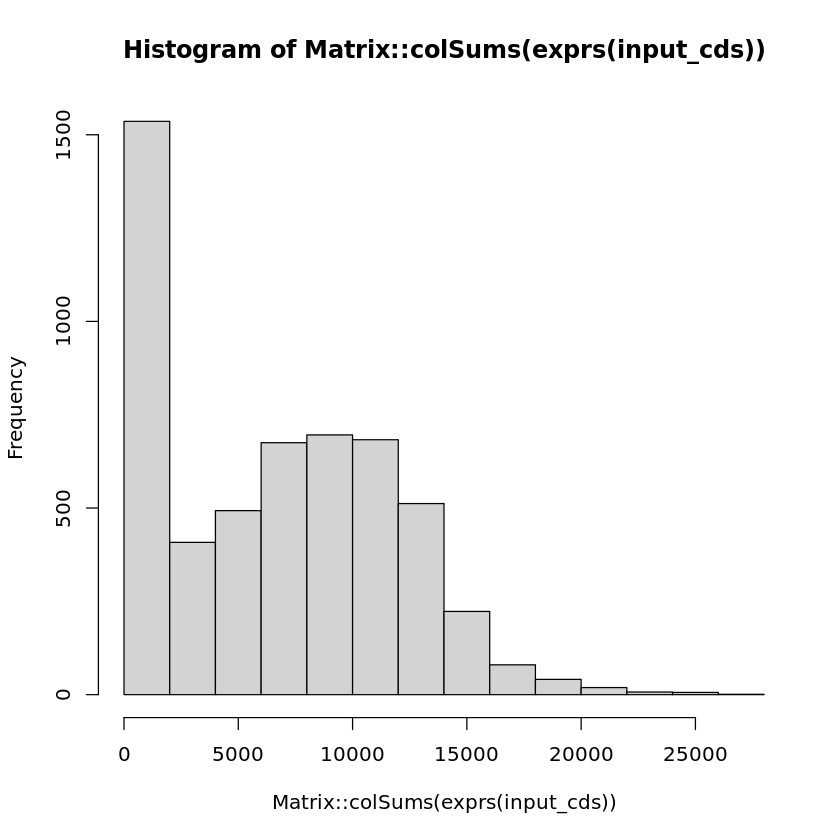

In [4]:
# Visualize peak_count_per_cell
hist(Matrix::colSums(exprs(input_cds)))

In [5]:
# Filter cells by peak_count
max_count <-  15000
min_count <- 2000
input_cds <- input_cds[,Matrix::colSums(exprs(input_cds)) >= min_count]
input_cds <- input_cds[,Matrix::colSums(exprs(input_cds)) <= max_count]

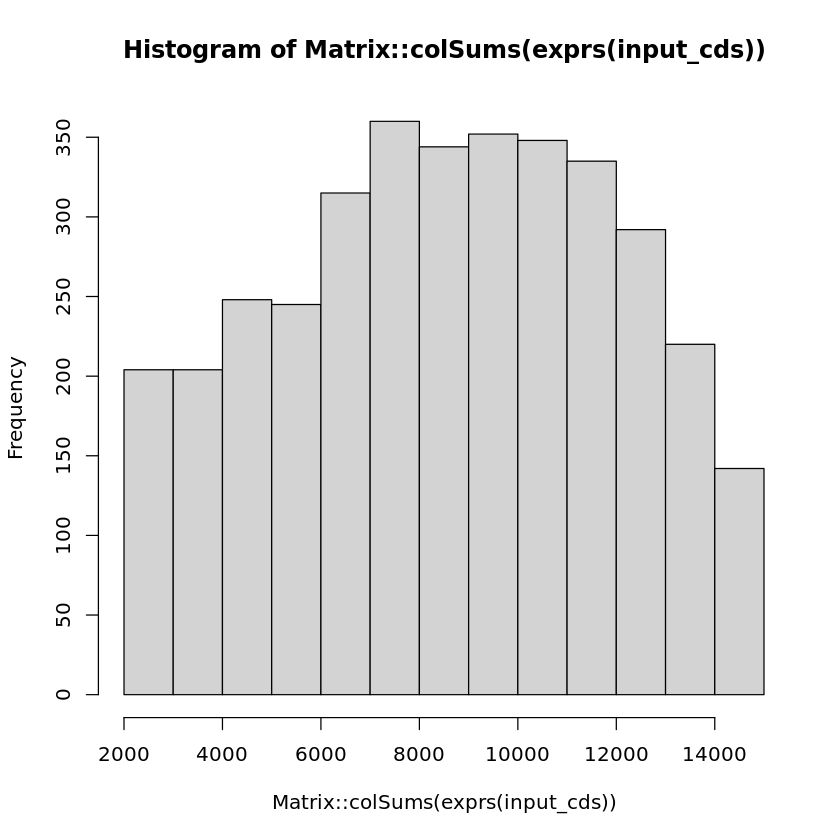

In [6]:
# Visualize peak_count_per_cell
hist(Matrix::colSums(exprs(input_cds)))

In [8]:
# Data preprocessing
set.seed(2017)

# Preprocess the data
input_cds <- detect_genes(input_cds)
input_cds <- estimate_size_factors(input_cds)
input_cds <- preprocess_cds(input_cds, method = "LSI")

# Dimensional reduction with umap
input_cds <- reduce_dimension(input_cds, reduction_method = 'UMAP',
                              preprocess_method = "LSI")
umap_coords <- reducedDims(input_cds)$UMAP

# Make cicero cds
cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = umap_coords)

Overlap QC metrics:
Cells per bin: 50
Maximum shared cells bin-bin: 44
Mean shared cells bin-bin: 0.828023724388444
Median shared cells bin-bin: 0



In [10]:
# Run the main function
conns <- run_cicero(cicero_cds, chromosome_length) # Takes a few minutes to run

# Check results
head(conns)

In [18]:
# Save csvs
all_peaks <- row.names(exprs(input_cds))
write.csv(x = all_peaks, file = paste0(output_folder, "/all_peaks.csv"))
write.csv(x = conns, file = paste0(output_folder, "/cicero_connections.csv"))

In [21]:
# Save CDS
saveRDS(cicero_cds, paste0(output_folder, "/cicero_cds.Rds"))

In [22]:
head(conns)

,Peak1,Peak2,coaccess
,<chr>,<fct>,<dbl>
1,chr10_100006139_100006389,chr10_99774288_99774570,-0.003923920
2,chr10_100006139_100006389,chr10_99825945_99826237,-0.024811034
3,chr10_100006139_100006389,chr10_99830012_99830311,0.006070376
4,chr10_100006139_100006389,chr10_99833211_99833540,-0.008155523
5,chr10_100006139_100006389,chr10_99941805_99941955,0.000000000
7,chr10_100006139_100006389,chr10_100015291_100017830,-0.010579116


# DONE!

---